## Guided Project: Credit Card Customer Segmentation

In this guided project, we’ll play the role of a data scientist working for a credit card company. We’ve been given a dataset containing information about the company’s clients and asked to help segment them into different groups in order to apply different business strategies for each type of customer.

The company expects to receive a group for each client and also an explanation of the characteristics of each group and what are the main points that make them different.

In a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

Analyze the dataset;
Prepare the data for modeling;
Find an appropriate number of clusters;
Segment the data;
Interpret and explain the results.
We'll start by importing the packages we'll use.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

sns.set_style('whitegrid')
%matplotlib inline

### Exploratory Data Analysis
After reading the data into pandas, it's time to explore it. Let's investigate the size of the dataset, what columns it contains, the type of values in each column, and also check on missing values.

In [4]:
import os
os.getcwd()

'/drive/data'

In [5]:
customers = pd.read_csv('/drive/data/customer_segmentation.csv')

customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [6]:
customers.shape

(10127, 14)

In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are 10127 rows and 14 columns in the dataset including a unique identifier for each client, which is not going to be needed for the segmentation.

Of the 13 columns left, there are 8 columns containing integers, 2 containing floats, and 3 columns containing strings, which means we have 3 categorical columns to deal with.

Also, there are no missing values.

In [8]:
for col in ['gender', 'education_level', 'marital_status']:
    print(col)
    print(customers[col].value_counts(), end='\n\n')

gender
F    5358
M    4769
Name: gender, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64



Here we can see how many unique categories are there in each categorical variable and how many datapoints per category.

As we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables.

But we can see the correlation between the numeric variables and their distributions.

<ipython-input-9-fda5d326c073>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(customers.drop('customer_id', axis=1).corr(), 2), cmap='Blues', annot=True, ax=ax)


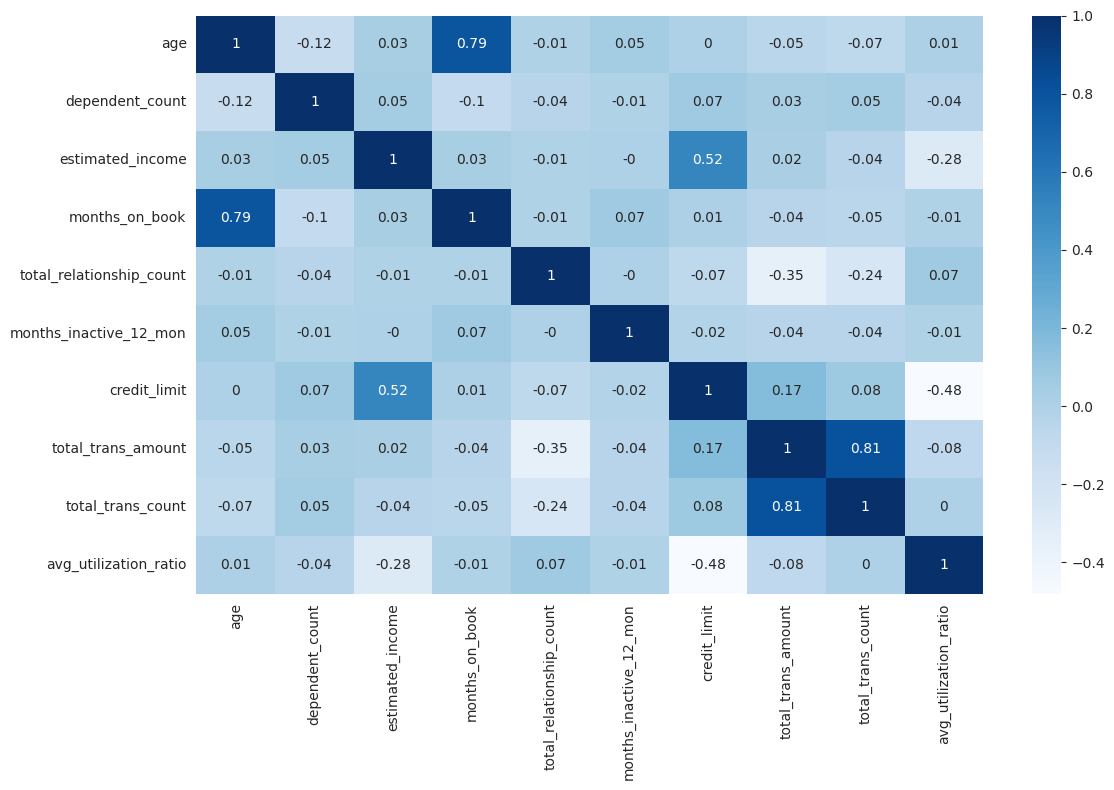

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(round(customers.drop('customer_id', axis=1).corr(), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

Most of the variables present weak correlations between each other, but there are some we can highlight:

Age is strongly correlated with how long the person has been a customer (months_on_book);
Credit limit is positively correlated with the estimated income and negatively correlated with the average utilization ratio;
The total number of transactions (total_trans_count) is strongly correlated with the total amount transitioned (total_trans_amount).

<ipython-input-10-d5d767247676>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  customers.drop('customer_id', axis=1).hist(ax=ax)


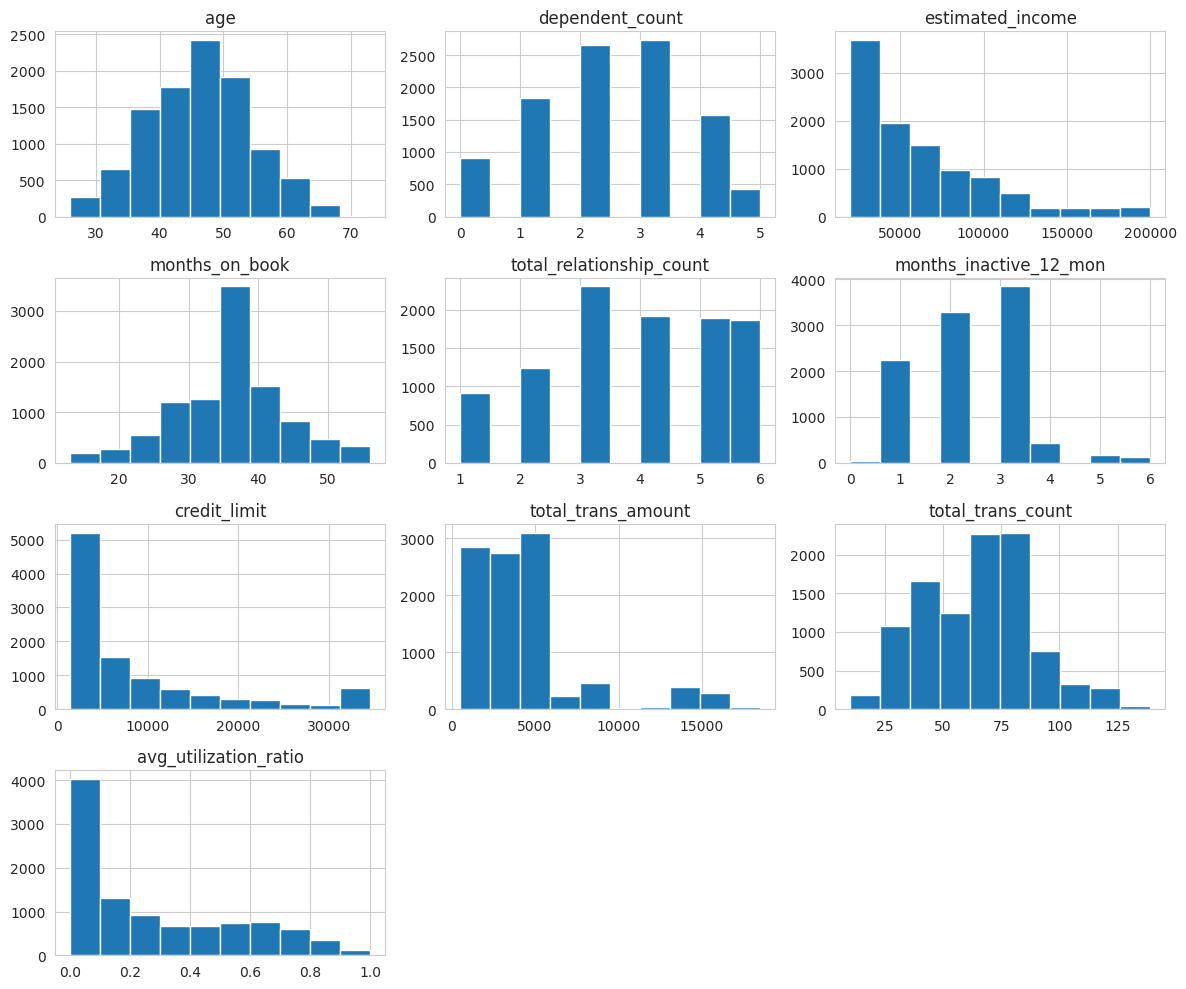

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

#Removing the customer's id before plotting the distributions
customers.drop('customer_id', axis=1).hist(ax=ax)

plt.tight_layout()
plt.show()

Regarding distributions, we have a couple of them closer to a normal distribution, but most of them are skewed.

Feature Engineering
We're now dealing with the 3 categorical variables.

The gender column is the easiest one. We'll use a lambda function to replace the values with ones and zeros.

We'll also be able to transform the education_level column to numeric. We'll use the replace() method to perform this task. This method will assign a value to each level of education:

Uneducated - 0
High School - 1
College - 2
Graduate - 3
Post-Graduate - 4
Doctorate - 5
Unfortunately, we can't do the same for this marital_status column as there is no level of magnitude between "Single", "Married" or "Divorced", for example. We can't say that any of them is higher or better than the others. Therefore, we'll use one-hot-encoding to create dummy variables from this column and then drop the original variable.

In [11]:
customers_modif = customers.copy()
customers_modif['gender'] = customers['gender'].apply(lambda x: 1 if x == 'M' else 0)
customers_modif.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [12]:
customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College':2,
                                    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate':5}, inplace=True)
customers_modif['education_level'].head()

0    1
1    3
2    3
3    1
4    0
Name: education_level, dtype: int64

In [13]:
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)

customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)
customers_modif.head()

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


Scaling the Data
First, we need to standardize the dataset. We'll use scikit-learn's StandardScaler() for this task.

In [14]:
X = customers_modif.drop('customer_id', axis=1)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-0.16540558,  1.05995565,  0.50336813, -0.75221102,  0.1758098 ,
         0.38462088,  0.76394261, -1.32713603,  0.4466219 , -0.95970657,
        -0.97389518, -0.77588223,  1.07733799, -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867,  0.66278684, -0.96716585,
         1.01071482,  1.40730617, -1.32713603, -0.04136665, -0.91643261,
        -1.35734038, -0.61627565, -0.92821381,  1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813,  0.66278684,  0.78539682,
         0.00896451,  0.12057905, -1.32713603, -0.5736978 , -0.74098169,
        -1.91120566, -0.99715499,  1.07733799, -0.79850685, -0.28260887],
       [-0.78912553, -0.9434357 ,  1.2732834 , -0.75221102, -0.63697289,
        -0.24147306, -0.52278451,  1.64147829, -0.58525108, -0.95175829,
        -1.91120566,  1.75968594, -0.92821381, -0.79850685,  3.53845931],
       [-0.78912553,  1.05995565,  0.50336813, -1.45970995,  0.07421197,
        -1.86931731,  0.76394261, -1.32713603, 

### Choosing K
Learn
Now our dataset is ready for machine learning. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric.

We'll have to create several models and compute the inertia from each of them. Then, we'll be able to plot the Elbow Curve and decide the number of clusters we'll use to segment the customers. Once we do all that, we can perform the real clusterization.

/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/lib/python3.11/site-packages/sklearn/cluster/_km

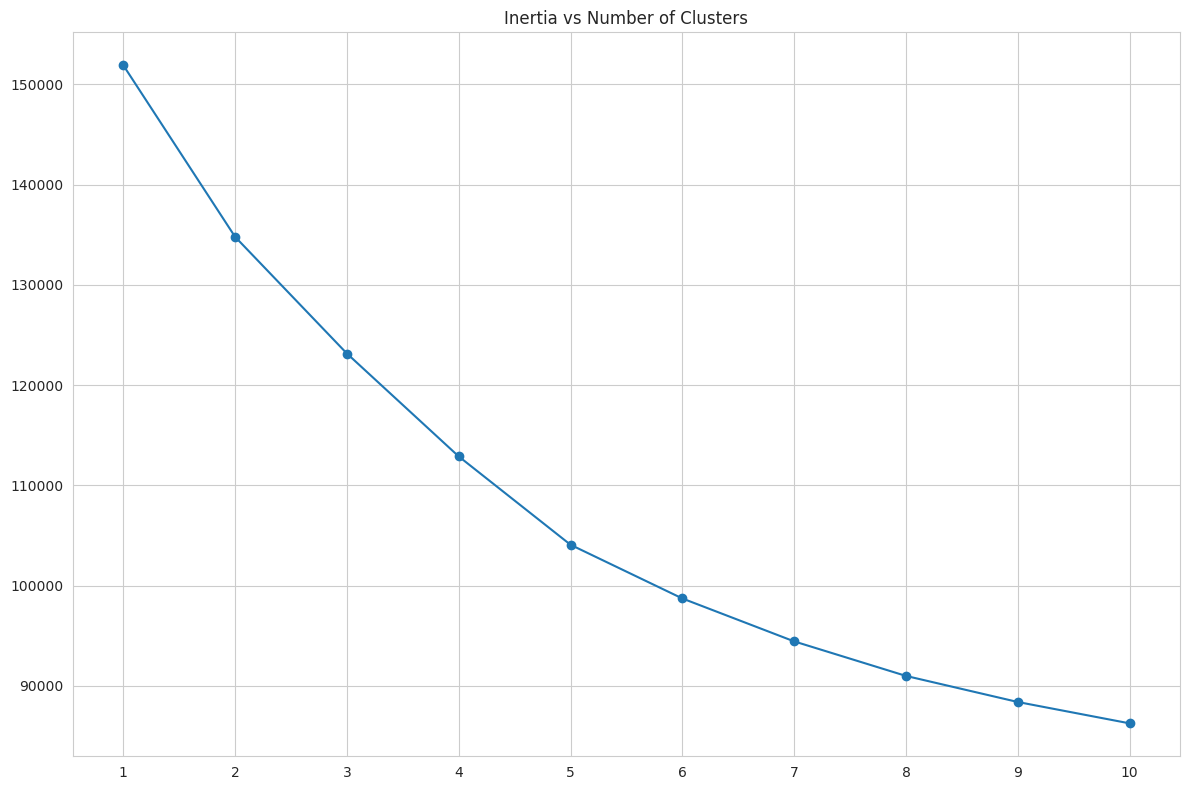

In [15]:
X = pd.DataFrame(X_scaled)
inertias = []

for k in range(1,11):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()


It looks like the rate of decreasing of the inertia slows down between 5 and 7 clusters. We'll use 6 clusters to move on.

In [16]:
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)

y

/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([3, 2, 3, ..., 5, 4, 5])

## Analyzing Results
Now, let's create a CLUSTER column in our original dataset so we can better understand the characteristics of each one.

In [22]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [23]:
customers['CLUSTER'] = y + 1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,4
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,3
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,4
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,5
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,2
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,6
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,6
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,5


In [24]:
customers['CLUSTER'].value_counts()

6    2786
3    2491
4    1758
1    1449
2     913
5     730
Name: CLUSTER, dtype: int64

We can see that cluster 2 is the largest while cluster 3 is the smallest.

Considering the numeric variable only, we'll check on the average value of each variable per cluster. We just need to group the data and plot a bar chart for each column.

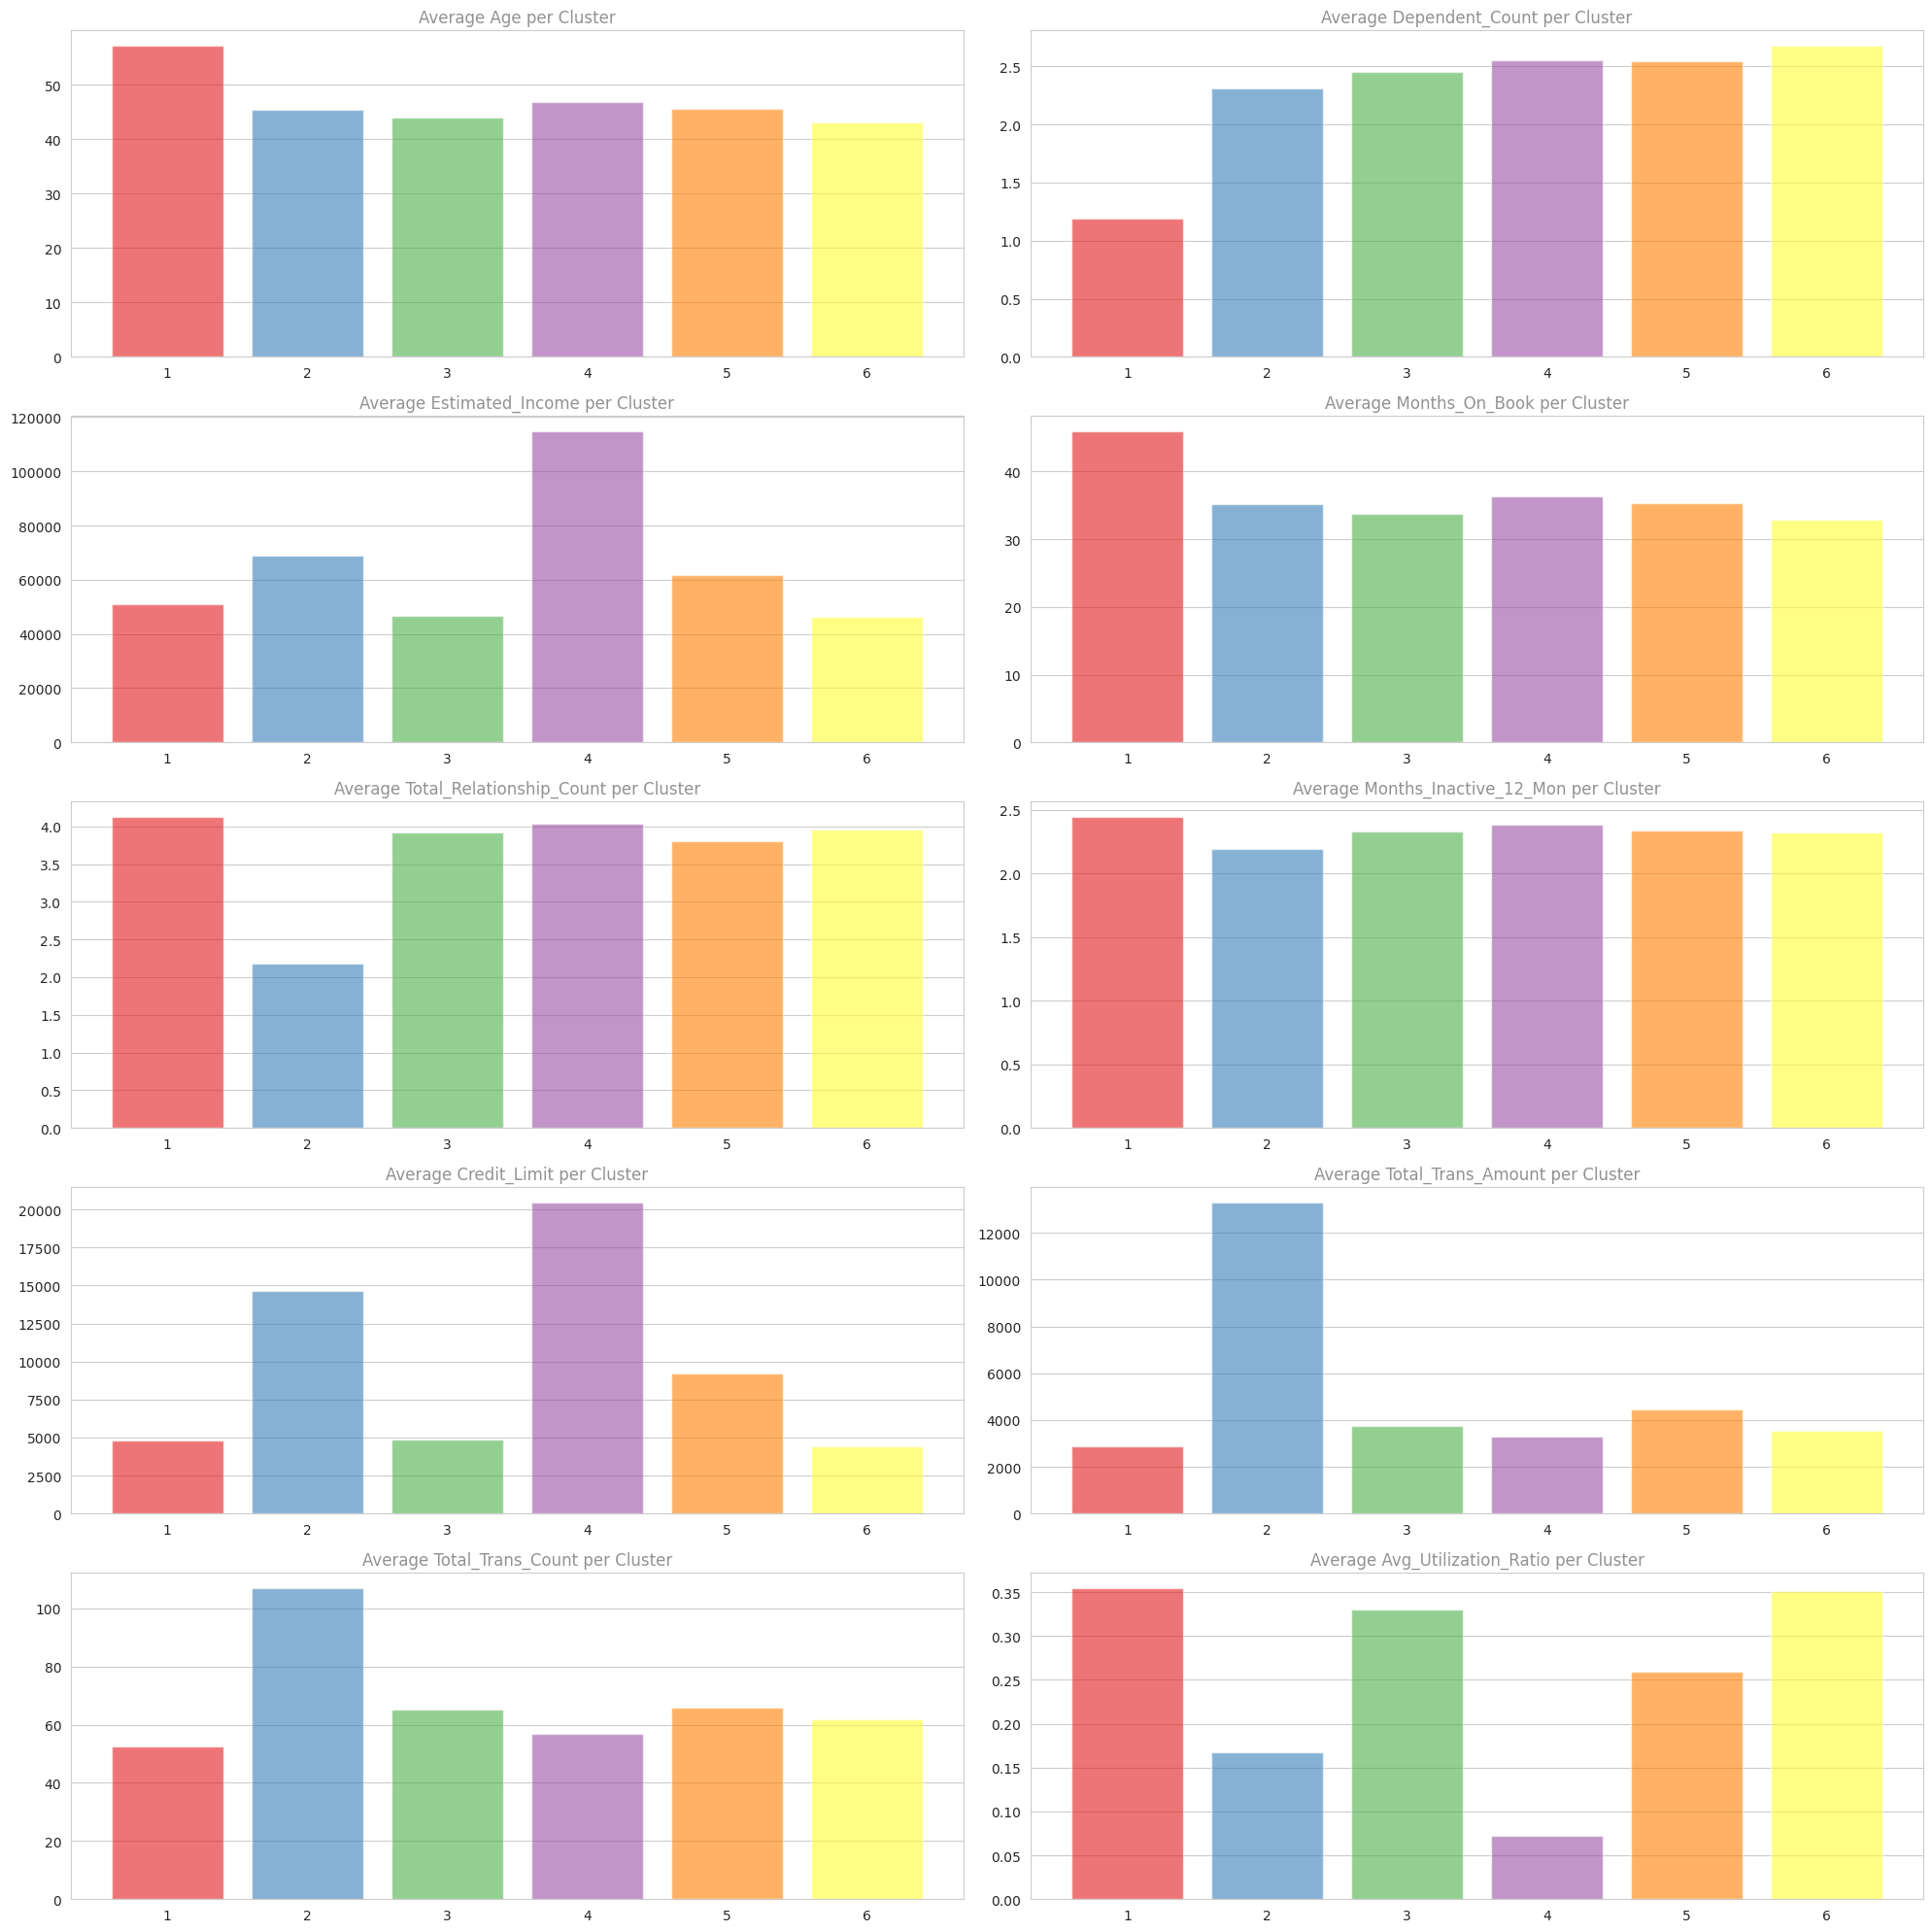

In [25]:
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For those numerical variables with higher correlations we saw earlier, we can also use a scatter plot to visualize this correlation grouped by clusters and analyze how the clusters change between each area of the chart.

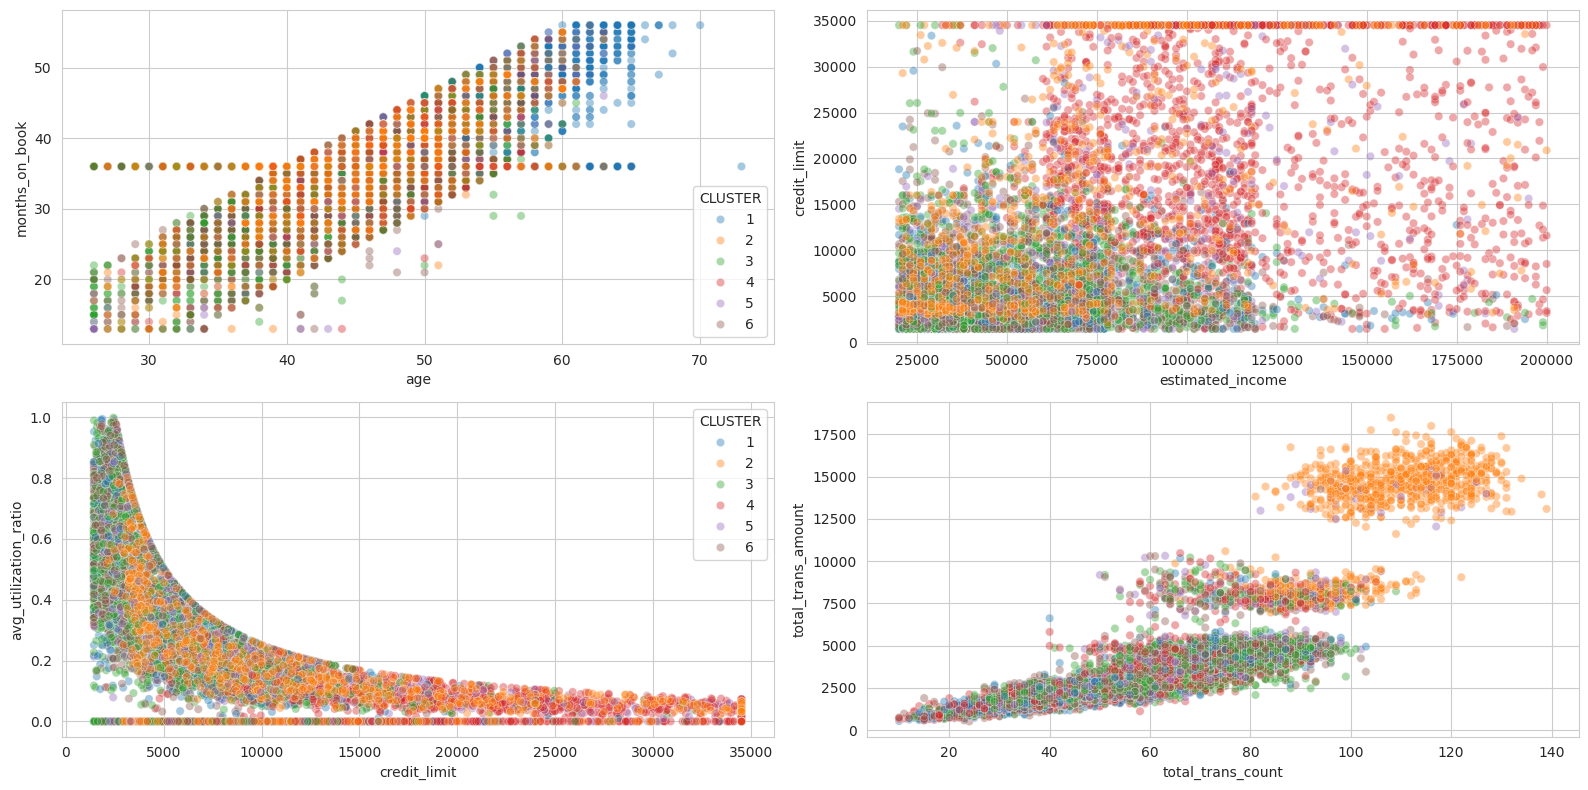

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

We can draw some early conclusions considering only the numeric variables.

For instance, Cluster 1 has the highest amount of money transitioned, while Cluster 2 has the lowest credit limit and estimated income and the highest utilization rate. Cluster 4 has the highest credit limit. Older clients are grouped in Cluster 5.

For the categorical columns, we'll plot the percentual distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

<ipython-input-27-1732a592747c>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-27-1732a592747c>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-27-1732a592747c>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


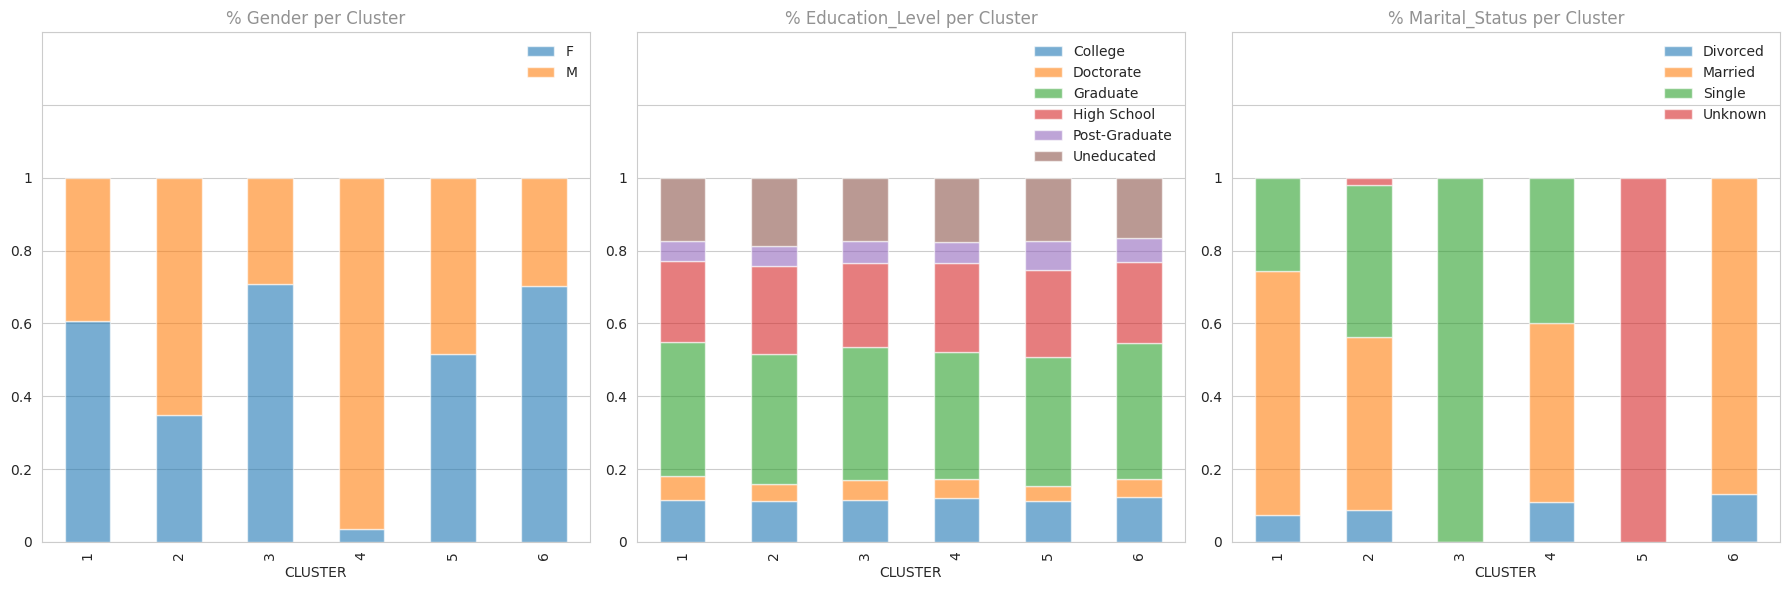

In [27]:
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

Considering the categorical variables, we notice that the education level is well divided between clusters.

In other highlights, Cluster 2 is composed almost entirely of married people, while we don't know the marital status of anybody in Cluster 3. Cluster 4 is almost completely male and Cluster 6 is 100% made of single people.

Conclusion
As demanded by the company, we now have listed the most important characteristics of each cluster. We could also some suggestions and insights into each one of them.

In the end, we have the list of customers with a cluster assigned to each one.

Cluster 1
Characteristics: Mostly men; high credit limit; high amount transitioned; high number of transactions; low utilization rate.

Insight: People with high volume spent on the card, but do not use it on a daily basis. Could be incentivised to spend more.

Cluster 2
Characteristics: Mostly women; mostly married; low estimated income; low credit limit; low amount transitioned; high utilization rate.

Insight: Married people (majority women) with low income and limit but utilize too much of their credit with a few larger purchases

Cluster 3
Cluster 3: Gender well divided; low credit limit, high utilization rate; marital status 100% unknown; smaller cluster.

Insight: Men and women with low credit limits but do have high balances.

Cluster 4
Cluster 4: Mostly men, mostly single and married, high estimated income, high credit limit; low amount transitioned; low utilization rate.

Insight: People (majority men) with high income and credit limits, but don't use the card. Could be incentivized to use it.

Cluster 5
Cluster 5: Mostly married, high age, low dependent count, long time customers, low credit limit, low amount transitioned, high utilization rate.

Insight: Older people and long-time customers. Low credit limit and transactions, but use the card very often. Could receive benefits to spend more money.

Cluster 6
Cluster 6: Mostly women; 100% single people, low estimated income, low credit limit, low amount transitioned, high utilization rate.

Insight: Single (mostly women) people that use their card a lot but have low credit limits and income. Could be given a bit more credit limit.

In [28]:
# List of customers and clusters
customers[['customer_id', 'CLUSTER']]

,customer_id,CLUSTER
0,768805383,4
1,818770008,3
2,713982108,4
3,769911858,5
4,709106358,6
...,...,...
10122,772366833,2
10123,710638233,6
10124,716506083,6
10125,717406983,5
